# Time_series_forecasting

In [125]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf


In [126]:
df=pd.read_csv('AusAntidiabeticDrug.csv')

In [127]:
df

,Date,Production
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


Data preprocessing 

In [128]:
df.describe()

,Production
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


In [129]:
df.dtypes

Date           object
Production    float64
dtype: object

In [130]:
#converting the datatype of date 

df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

Date          datetime64[ns]
Production           float64
dtype: object


In [131]:
#checking for null values 
df.isna().sum()

Date          0
Production    0
dtype: int64

In [132]:
#checking for outliers

# Calculating z-scores for the 'production' column
z_scores = (df['Production'] - df['Production'].mean()) / df['Production'].std()

# Defining a threshold for outlier detection (e.g., z-score > 3 or < -3)
threshold = 3

# Identifying the rows with outliers
outliers = df[abs(z_scores) > threshold]
print(outliers)

# Remove the outliers from the DataFrame
df = df.drop(outliers.index)

# Print the updated DataFrame
print('..........................................')
print('updated dataframe ')
print(df)

          Date  Production
198 2008-01-01   29.665356
..........................................
updated dataframe 
          Date  Production
0   1991-07-01    3.526591
1   1991-08-01    3.180891
2   1991-09-01    3.252221
3   1991-10-01    3.611003
4   1991-11-01    3.565869
..         ...         ...
199 2008-02-01   21.654285
200 2008-03-01   18.264945
201 2008-04-01   23.107677
202 2008-05-01   22.912510
203 2008-06-01   19.431740

[203 rows x 2 columns]


resampling the dataset 

In [133]:


# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Resample data to weekly frequency
df_weekly = df.resample('W').mean()

# Resample data to monthly frequency
df_monthly = df.resample('M').mean()

In [134]:
df

,Production
Date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [135]:
print("Weekly Resampled Data:")
df_weekly.head()

Weekly Resampled Data:


,Production
Date,
1991-07-07,3.526591
1991-07-14,NaN
1991-07-21,NaN
1991-07-28,NaN
1991-08-04,3.180891


In [136]:

# Forward filling missing values
df_weekly = df_weekly.ffill()

# Printing the resampled data
print(df_weekly)

            Production
Date                  
1991-07-07    3.526591
1991-07-14    3.526591
1991-07-21    3.526591
1991-07-28    3.526591
1991-08-04    3.180891
...                ...
2008-05-04   22.912510
2008-05-11   22.912510
2008-05-18   22.912510
2008-05-25   22.912510
2008-06-01   19.431740

[883 rows x 1 columns]


In [137]:


# Performing Augmented Dickey-Fuller test
result = adfuller(df_weekly)

# Extracting and printing the p-value
p_value = result[1]
print("p-value:", p_value)

# Interpreting the test result
if p_value < 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")


p-value: 0.8122431490861732
The data is non-stationary.


since the data is non stationary making it stationary through logarithmic transformation

In [138]:

# Apply logarithmic transformation
log_transformed_data_weekly = np.log(df_weekly)

print("Original Data:")
print(df_weekly)
print("\nLogarithmic Transformed Data:")
print(log_transformed_data_weekly)


Original Data:
            Production
Date                  
1991-07-07    3.526591
1991-07-14    3.526591
1991-07-21    3.526591
1991-07-28    3.526591
1991-08-04    3.180891
...                ...
2008-05-04   22.912510
2008-05-11   22.912510
2008-05-18   22.912510
2008-05-25   22.912510
2008-06-01   19.431740

[883 rows x 1 columns]

Logarithmic Transformed Data:
            Production
Date                  
1991-07-07    1.260332
1991-07-14    1.260332
1991-07-21    1.260332
1991-07-28    1.260332
1991-08-04    1.157161
...                ...
2008-05-04    3.131683
2008-05-11    3.131683
2008-05-18    3.131683
2008-05-25    3.131683
2008-06-01    2.966908

[883 rows x 1 columns]


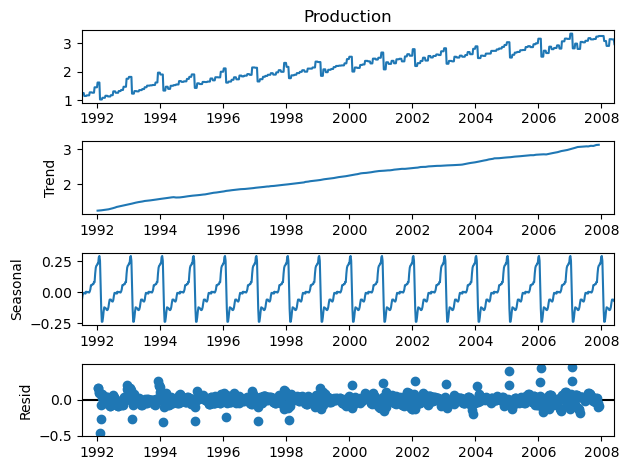

In [139]:
results = seasonal_decompose(log_transformed_data_weekly['Production'])
results.plot();

In [140]:
print("Monthly Data:")
df_monthly.head()

Monthly Data:


,Production
Date,
1991-07-31,3.526591
1991-08-31,3.180891
1991-09-30,3.252221
1991-10-31,3.611003
1991-11-30,3.565869


In [141]:
# Forward filling missing values
df_monthly= df_monthly.ffill()

# Perform Augmented Dickey-Fuller test
result = adfuller(df_monthly)

# Extract and print the p-value
p_value = result[1]
print("p-value:", p_value)

# Interpret the test result
if p_value < 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")


p-value: 1.0
The data is non-stationary.


since the data is non stationary making it stationary through logarithmic transformation

In [142]:

# Apply logarithmic transformation
log_transformed_data_monthly = np.log(df_monthly)

print("Original Data:")
print(df_monthly)
print("\nLogarithmic Transformed Data:")
print(log_transformed_data_monthly)


Original Data:
            Production
Date                  
1991-07-31    3.526591
1991-08-31    3.180891
1991-09-30    3.252221
1991-10-31    3.611003
1991-11-30    3.565869
...                ...
2008-02-29   21.654285
2008-03-31   18.264945
2008-04-30   23.107677
2008-05-31   22.912510
2008-06-30   19.431740

[204 rows x 1 columns]

Logarithmic Transformed Data:
            Production
Date                  
1991-07-31    1.260332
1991-08-31    1.157161
1991-09-30    1.179338
1991-10-31    1.283986
1991-11-30    1.271408
...                ...
2008-02-29    3.075203
2008-03-31    2.904984
2008-04-30    3.140165
2008-05-31    3.131683
2008-06-30    2.966908

[204 rows x 1 columns]


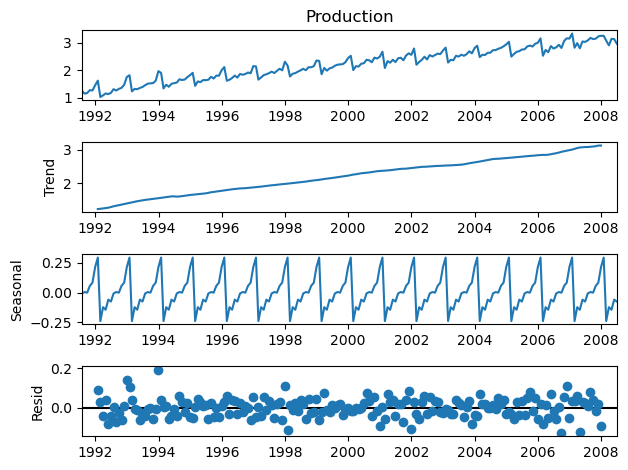

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(log_transformed_data_monthly['Production'])
result.plot();

# Time series forecasting in weekly data

In [147]:


# Prepariing the Data

scaler = MinMaxScaler()
df_weekly['Production'] = scaler.fit_transform(df_weekly['Production'].values.reshape(-1, 1))

#  Splitting the Data
train_size = int(len(df_weekly) * 0.8)
train_data = df_weekly[:train_size]
test_data = df_weekly[train_size:]

#  Creating Sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10
X_train, y_train = create_sequences(train_data.values, sequence_length)
X_test, y_test = create_sequences(test_data.values, sequence_length)

# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the Model
epochs = 100
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Making Predictions
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)






Epoch 1/100
22/22 [==============================] - 1s 3ms/step - loss: 0.0360
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 11/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 13/100
22/22 [=================

In [148]:
# Printing actual and predicted values
test_actual = scaler.inverse_transform(y_test).flatten()

print("\nActual vs Predicted Production (Test Set):")
for actual, predicted in zip(test_actual, test_predictions):
    print(f"Actual: {actual:.2f} | Predicted: {predicted[0]:.2f}")



Actual vs Predicted Production (Test Set):
Actual: 0.42 | Predicted: 0.45
Actual: 0.46 | Predicted: 0.44
Actual: 0.46 | Predicted: 0.47
Actual: 0.46 | Predicted: 0.46
Actual: 0.46 | Predicted: 0.46
Actual: 0.47 | Predicted: 0.46
Actual: 0.47 | Predicted: 0.47
Actual: 0.47 | Predicted: 0.48
Actual: 0.47 | Predicted: 0.48
Actual: 0.47 | Predicted: 0.48
Actual: 0.51 | Predicted: 0.48
Actual: 0.51 | Predicted: 0.51
Actual: 0.51 | Predicted: 0.51
Actual: 0.51 | Predicted: 0.51
Actual: 0.52 | Predicted: 0.51
Actual: 0.52 | Predicted: 0.52
Actual: 0.52 | Predicted: 0.52
Actual: 0.52 | Predicted: 0.52
Actual: 0.52 | Predicted: 0.52
Actual: 0.58 | Predicted: 0.53
Actual: 0.58 | Predicted: 0.59
Actual: 0.58 | Predicted: 0.58
Actual: 0.58 | Predicted: 0.58
Actual: 0.61 | Predicted: 0.58
Actual: 0.61 | Predicted: 0.60
Actual: 0.61 | Predicted: 0.61
Actual: 0.61 | Predicted: 0.61
Actual: 0.58 | Predicted: 0.61
Actual: 0.58 | Predicted: 0.59
Actual: 0.58 | Predicted: 0.60
Actual: 0.58 | Predicted: 

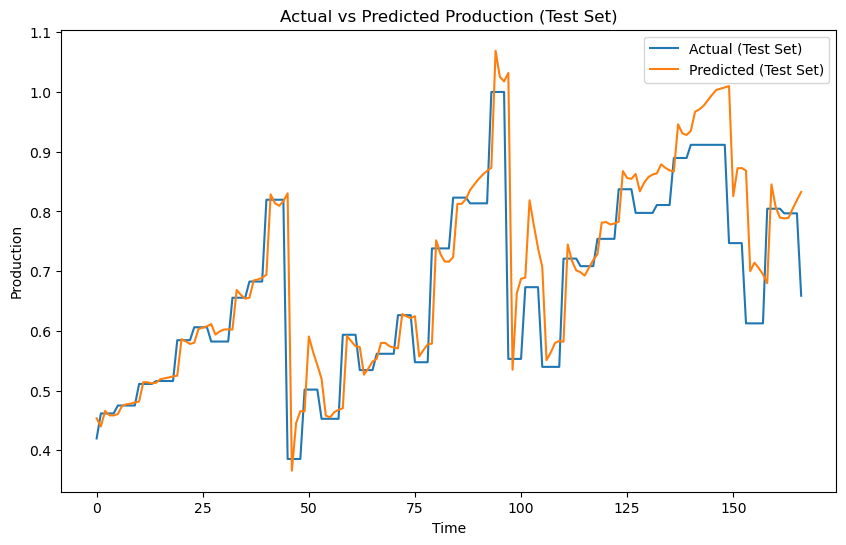

In [149]:


# Plotting predicted vs actual values for the test set
plt.figure(figsize=(10, 6))
plt.plot(test_actual, label='Actual (Test Set)')
plt.plot(test_predictions, label='Predicted (Test Set)')
plt.xlabel('Time')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production (Test Set)')
plt.legend()
plt.show()


# Time series forecasting in monthly data

In [122]:


# Prepareingthe Data

scaler = MinMaxScaler()
df_monthly['Production'] = scaler.fit_transform(df_monthly['Production'].values.reshape(-1, 1))

# Splitting the Data
train_size = int(len(df_monthly) * 0.8)
train_data = df_monthly[:train_size]
test_data = df_monthly[train_size:]

# Creating  Sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10
X_train, y_train = create_sequences(train_data.values, sequence_length)
X_test, y_test = create_sequences(test_data.values, sequence_length)

# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the Model
epochs = 100
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

#  Making Predictions
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)






Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.0783
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0572
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0301
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 6/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 11/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 12/100
5/5 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 13/100
5/5 [==============================] - 0s 3ms/st

In [123]:
# Print actual and predicted values
test_actual = scaler.inverse_transform(y_test).flatten()

print("\nActual vs Predicted Production (Test Set):")
for actual, predicted in zip(test_actual, test_predictions):
    print(f"Actual: {actual:.2f} | Predicted: {predicted[0]:.2f}")



Actual vs Predicted Production (Test Set):
Actual: 20.03 | Predicted: 17.81
Actual: 23.49 | Predicted: 18.80
Actual: 12.54 | Predicted: 20.30
Actual: 15.47 | Predicted: 19.10
Actual: 14.23 | Predicted: 18.97
Actual: 17.78 | Predicted: 18.44
Actual: 16.29 | Predicted: 18.80
Actual: 16.98 | Predicted: 18.59
Actual: 18.61 | Predicted: 18.60
Actual: 16.62 | Predicted: 18.97
Actual: 21.43 | Predicted: 18.61
Actual: 23.58 | Predicted: 19.23
Actual: 23.33 | Predicted: 19.97
Actual: 28.04 | Predicted: 21.36
Actual: 16.76 | Predicted: 23.45
Actual: 19.79 | Predicted: 22.86
Actual: 16.43 | Predicted: 23.15
Actual: 21.00 | Predicted: 22.56
Actual: 20.68 | Predicted: 23.17
Actual: 21.83 | Predicted: 23.42
Actual: 23.93 | Predicted: 24.07
Actual: 22.93 | Predicted: 24.70
Actual: 23.26 | Predicted: 24.64
Actual: 25.25 | Predicted: 24.76
Actual: 25.81 | Predicted: 25.08
Actual: 25.81 | Predicted: 26.34
Actual: 21.65 | Predicted: 27.29
Actual: 18.26 | Predicted: 27.46
Actual: 23.11 | Predicted: 26.48

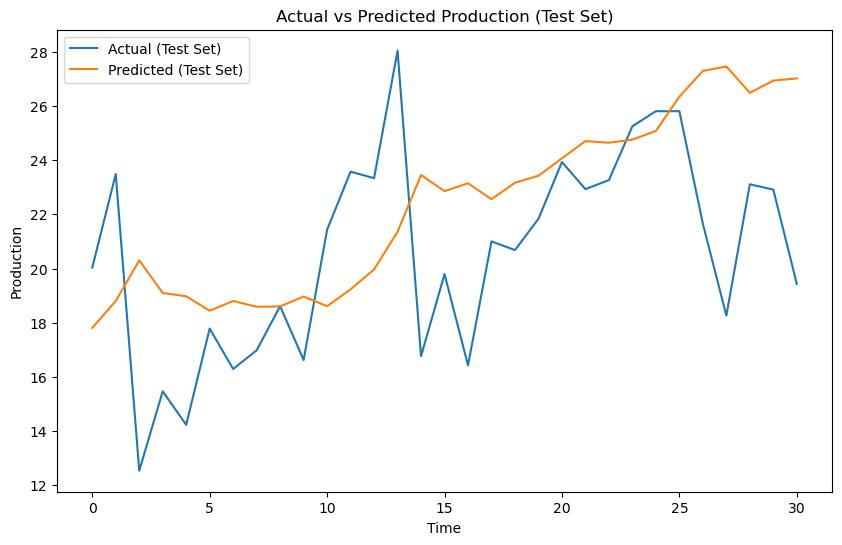

In [124]:
# Plotting predicted vs actual values for the test set
plt.figure(figsize=(10, 6))
plt.plot(test_actual, label='Actual (Test Set)')
plt.plot(test_predictions, label='Predicted (Test Set)')
plt.xlabel('Time')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production (Test Set)')
plt.legend()
plt.show()
